## Семинар 7: "Методы оптимизации"

ФИО: Каспарьянц Георгий Григорьевич

In [3]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import Optimizer
from tqdm import tqdm
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [4]:
class GD:
    def __init__(self, x, fn, dfn, lr):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(lr=lr)
    def __call__(self):
        grad = self.dfn(self.x)
        self.x -= self.params['lr'] * grad
        return self.x

In [5]:
class Momentum:
    def __init__(self, x, fn, dfn, lr, gamma=0.9):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(lr=lr, gamma=gamma)
        self._last_grad = np.zeros_like(x)
    def __call__(self):
        grad = self.params['gamma'] * self._last_grad + self.params['lr'] * self.dfn(self.x)
        self.x -= grad
        self._last_grad = grad
        return self.x

In [6]:
class NAG:
    def __init__(self, x, fn, dfn, lr, gamma=0.9):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(lr=lr, gamma=gamma)
        self._last_grad = np.zeros_like(x)
    def __call__(self):
        grad = self.params['gamma'] * self._last_grad + self.params['lr'] * self.dfn(self.x - self.params['gamma'] * self._last_grad)
        self.x -= grad
        self._last_grad = grad
        return self.x

In [7]:
class Adagrad:
    def __init__(self, x, fn, dfn, lr, eps=0.000000001):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(lr=lr)
        self.grad_sum = np.zeros_like(x) + eps
    def __call__(self):
        grad = self.dfn(self.x)
        self.grad_sum += grad**2
        self.x -= self.params['lr'] * grad / np.sqrt(self.grad_sum)
        return self.x

In [8]:
class Adadelta:
    def __init__(self, x, fn, dfn, lr, gamma=0.9, eps=0.000000001):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(gamma=gamma)
        self.grad_sum = np.zeros_like(x) + eps
        self.acc_delta = np.zeros_like(x) + lr
    def __call__(self):
        grad = self.dfn(self.x)
        self.grad_sum += self.params['gamma'] * self.grad_sum + (1-self.params['gamma']) * grad**2
        self.acc_delta = self.acc_delta / np.sqrt(self.grad_sum) * grad
        self.x -= self.acc_delta
        return self.x

In [9]:
class Adam:
    def __init__(self, x, fn, dfn, lr, beta1=0.9, beta2=0.999, eps=0.000000001):
        self.x = np.array(x, dtype=np.float64)
        self.fn = fn
        self.dfn = dfn
        self.params = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        self.m = 0
        self.v = 0
        self.t = 0
        
    def __call__(self):
        self.t += 1
        grad = self.dfn(self.x)
        
        self.m = self.params['beta1'] * self.m + (1 - self.params['beta1']) * grad
        self.v = self.params['beta2'] * self.v + (1 - self.params['beta2']) * (grad**2)
        
        m_ = self.m / (1 - (self.params['beta1']**self.t))
        v_ = self.v / (1 - (self.params['beta2']**self.t))
        
        self.x -= self.params['lr'] * m_ / np.sqrt(v_ + self.params['eps'])
        return self.x

In [10]:
def draw(Opt, f, df, *args):
    opt = Opt([3, 0], f, df, *args)
    arr = []
    for i in range(1000):
        val = opt()
        arr.append(list(val))
    arr = np.array(arr)
    x, y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
    print(str(Opt))
    plt.contour(x, y, f((x, y)), 30)
    plt.scatter(arr[:, 0], arr[:,1])
    plt.show()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

__main__.GD


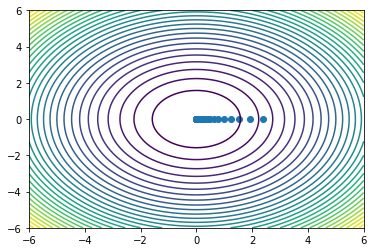

__main__.Momentum


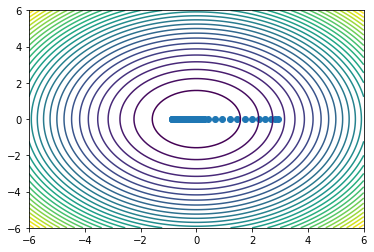

__main__.NAG


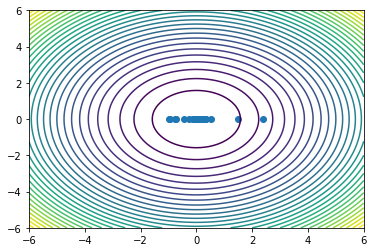

__main__.Adagrad


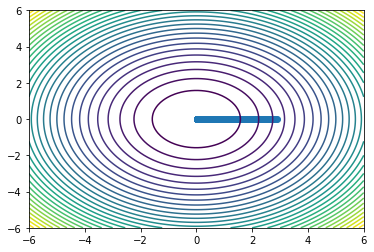

__main__.Adadelta


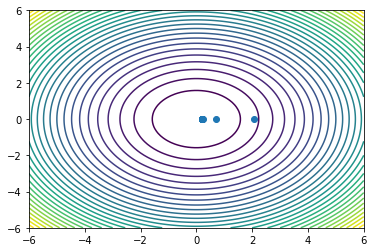

__main__.Adam


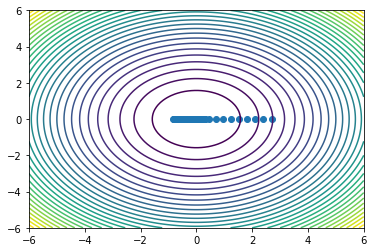

In [11]:
f = lambda X: X[0]**2 + X[1]**2
df = lambda X: np.array([2 * X[0], 2 * X[1]])
draw(GD, f, df, 0.1)
draw(Momentum, f, df, 0.01)
draw(NAG, f, df, 0.1)
draw(Adagrad, f, df, 0.1)
draw(Adadelta, f, df, 0.3)
draw(Adam, f, df, 0.3)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

__main__.GD


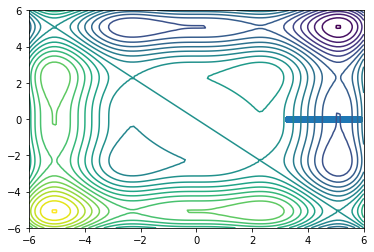

__main__.Momentum


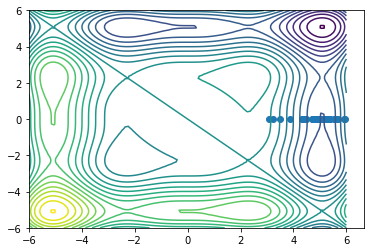

__main__.NAG


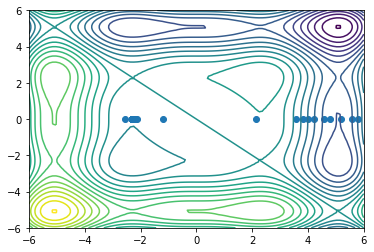

__main__.Adagrad


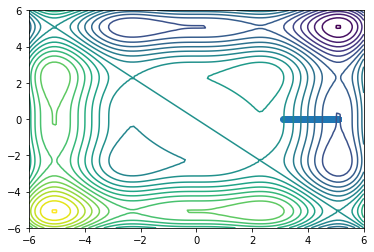

__main__.Adadelta


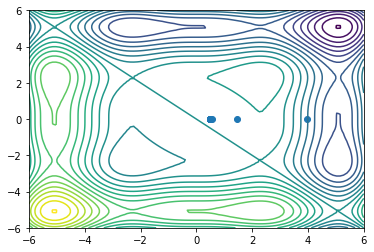

__main__.Adam


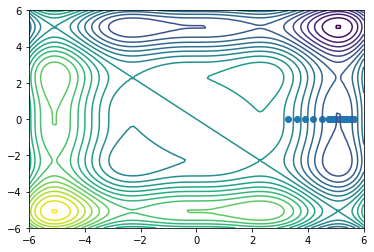

In [12]:
f = lambda x : np.sin(x[0]) * (x[0]**2) + np.sin(x[1]) * (x[1]**2)
df = lambda x : np.array([2 * np.sin(x[0]) * x[0] + np.cos(x[0])*(x[0]**2), 
                          2 * np.sin(x[1]) * x[1] + np.cos(x[1])*(x[1]**2)
                        ])
draw(GD, f, df, 0.1)
draw(Momentum, f, df, 0.01)
draw(NAG, f, df, 0.1)
draw(Adagrad, f, df, 0.1)
draw(Adadelta, f, df, 0.3)
draw(Adam, f, df, 0.3)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

/home/delta37/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
/home/delta37/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sin
  from ipykernel import kernelapp as app
/home/delta37/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in cos
  from ipykernel import kernelapp as app


__main__.GD


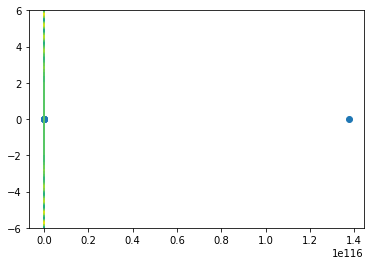

__main__.Momentum


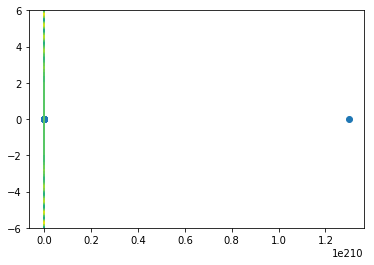

__main__.NAG


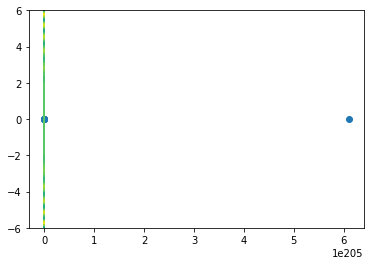

__main__.Adagrad


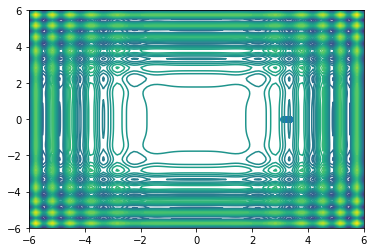

__main__.Adadelta


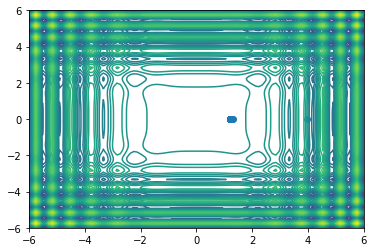

__main__.Adam


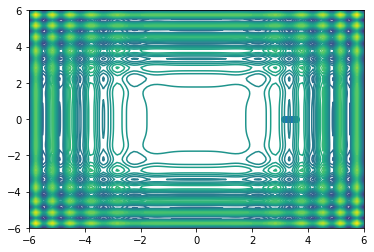

In [13]:
f = lambda x : np.sin(x[0]**2) * (x[0]**2) + np.sin(x[1]**2) * (x[1]**2)
df = lambda x : np.array([2 * np.sin(x[0]**2) * x[0] + 2 * np.cos(x[0]**2)*(x[0]**3), 
                          2 * np.sin(x[1]**2) * x[1] + 2 * np.cos(x[1]**2)*(x[1]**3), 
                        ])
draw(GD, f, df, 0.1)
draw(Momentum, f, df, 0.01)
draw(NAG, f, df, 0.1)
draw(Adagrad, f, df, 0.1)
draw(Adadelta, f, df, 0.3)
draw(Adam, f, df, 0.3)

###  Часть 2: Обучение нейронной сети

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD (на MNIST). </i>

In [15]:
bsize=20
dataset = datasets.MNIST(download=True, train=True, root='./data', transform=Compose([ToTensor()]))
dataloader = DataLoader(dataset, shuffle=True, batch_size=bsize)
epoch=2

In [16]:
model1 = nn.Sequential(nn.Linear(28 * 28, 10), nn.LogSoftmax())
lossfn1 = nn.NLLLoss()
opt1 = torch.optim.Adam(model1.parameters())
losses1 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        y_pred = model1(Variable(batch.view(bsize, -1)))
        
        
        loss = lossfn1(y_pred, y)
        
        losses1.append(loss.data.numpy()[0])
        opt1.zero_grad()
        loss.backward()
        
        opt1.step()

100%|██████████| 3000/3000 [00:30<00:00, 96.95it/s] 


In [18]:
model2 = nn.Sequential(nn.Linear(28 * 28, 10), nn.LogSoftmax())
lossfn2 = nn.NLLLoss()
opt2 = torch.optim.SGD(model2.parameters(), nesterov=True, lr=0.1, dampening=0, momentum=0.9)
losses2 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        y_pred = model2(Variable(batch.view(bsize, -1)))
        
        
        loss = lossfn2(y_pred, y)
        
        losses2.append(loss.data.numpy()[0])
        opt2.zero_grad()
        loss.backward()
        
        opt2.step()


  6%|▋         | 192/3000 [00:01<00:28, 98.55it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/delta37/anaconda3/envs/py27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/delta37/anaconda3/envs/py27/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/delta37/anaconda3/envs/py27/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


 50%|█████     | 1503/3000 [00:16<00:16, 91.85it/s]


100%|██████████| 3000/3000 [00:29<00:00, 101.81it/s]


In [19]:
model3 = nn.Sequential(nn.Linear(28 * 28, 10), nn.LogSoftmax())
lossfn3 = nn.NLLLoss()
opt3 = torch.optim.SGD(model3.parameters(), lr=0.1)
losses3 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        y_pred = model2(Variable(batch.view(bsize, -1)))
        
        
        loss = lossfn3(y_pred, y)
        
        losses3.append(loss.data.numpy()[0])
        opt3.zero_grad()
        loss.backward()
        
        opt3.step()

100%|██████████| 3000/3000 [00:26<00:00, 111.59it/s]


Adam


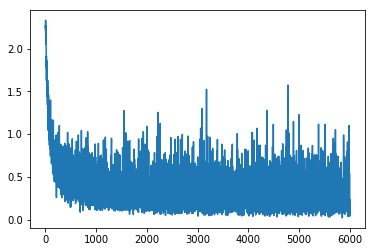

NAG


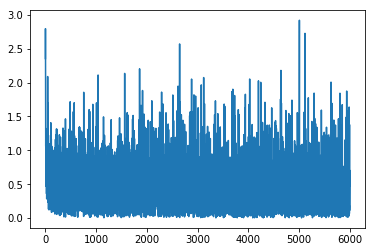

SGD


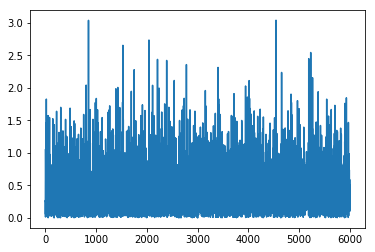

In [20]:
print("Adam")
plt.plot(losses1)
plt.show()
print("NAG")
plt.plot(losses2)
plt.show()
print("SGD")
plt.plot(losses3)
plt.show()

0


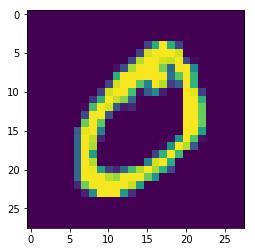

0


In [21]:
plt.imshow(dataset[1][0].numpy()[0])
print(dataset[1][1])
plt.show()
batch = Variable(torch.FloatTensor(dataset[1][0]))
y_pred = model1(batch.view(1, -1))
print(np.argmax(y_pred.data.numpy()))

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [22]:
bsize=20
dataset = datasets.MNIST(download=True, train=True, root='./data', transform=Compose([ToTensor()]))
dataloader = DataLoader(dataset, shuffle=True, batch_size=bsize)
epoch=2

In [23]:
feature1 = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
classifier1 = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
lossfn1 = nn.NLLLoss()
params = list(feature1.parameters()) + list(classifier1.parameters())
opt1 = torch.optim.Adam(params)
losses1 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        x = feature1(Variable(batch.view(bsize, 1, 28, 28)))
        x = x.view(-1, 20)
        y_pred = classifier1(x)
        
        
        loss = lossfn1(y_pred, y)
        
        losses1.append(loss.data.numpy()[0])
        opt1.zero_grad()
        loss.backward()
        
        opt1.step()

100%|██████████| 3000/3000 [01:12<00:00, 41.34it/s]


In [27]:
feature2 = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
classifier2 = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
lossfn2 = nn.NLLLoss()
params = list(feature2.parameters()) + list(classifier2.parameters())
opt2 = torch.optim.SGD(params, nesterov=True, lr=0.1, dampening=0, momentum=0.9)
losses2 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        x = feature2(Variable(batch.view(bsize, 1, 28, 28)))
        x = x.view(-1, 20)
        y_pred = classifier2(x)
        
        
        loss = lossfn2(y_pred, y)
        
        losses2.append(loss.data.numpy()[0])
        opt2.zero_grad()
        loss.backward()
        
        opt2.step()

100%|██████████| 3000/3000 [01:45<00:00, 28.45it/s]


In [28]:
feature3 = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
classifier3 = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
lossfn3 = nn.NLLLoss()
params = list(feature3.parameters()) + list(classifier3.parameters())
opt3 = torch.optim.SGD(params, lr=0.1)
losses3 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        x = feature3(Variable(batch.view(bsize, 1, 28, 28)))
        x = x.view(-1, 20)
        y_pred = classifier3(x)
        
        
        loss = lossfn3(y_pred, y)
        
        losses3.append(loss.data.numpy()[0])
        opt3.zero_grad()
        loss.backward()
        
        opt3.step()

100%|██████████| 3000/3000 [01:38<00:00, 30.60it/s]


Adam


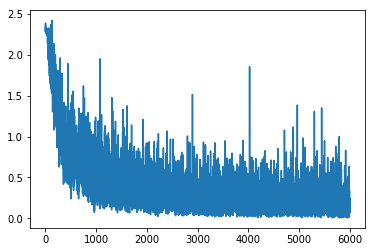

NAG


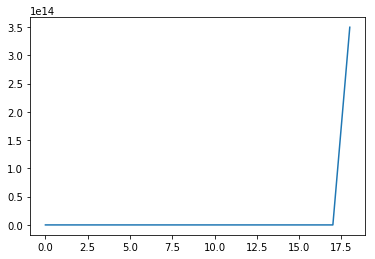

SGD


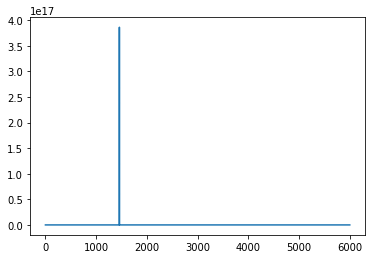

In [32]:
print("Adam")
plt.plot(losses1)
plt.show()
print("NAG")
plt.plot(losses2)
plt.show()
print("SGD")
plt.plot(losses3)
plt.show()

In [34]:
# Были слишком больште значения - градиенты сильно возросли

In [35]:
feature2 = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
classifier2 = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
lossfn2 = nn.NLLLoss()
params = list(feature2.parameters()) + list(classifier2.parameters())
opt2 = torch.optim.SGD(params, nesterov=True, lr=0.01, dampening=0, momentum=0.9)
losses2 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        x = feature2(Variable(batch.view(bsize, 1, 28, 28)))
        x = x.view(-1, 20)
        y_pred = classifier2(x)
        
        
        loss = lossfn2(y_pred, y)
        
        losses2.append(loss.data.numpy()[0])
        opt2.zero_grad()
        loss.backward()
        
        opt2.step()

100%|██████████| 3000/3000 [01:32<00:00, 32.30it/s]


NAG


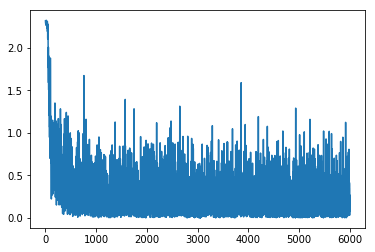

In [36]:
print("NAG")
plt.plot(losses2)
plt.show()

In [37]:
feature3 = nn.Sequential(
    nn.Conv2d(1, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.Conv2d(5, 5, 5, bias=True), 
    nn.ReLU(),
)
classifier3 = nn.Sequential(
    nn.Linear(20, 10),
    nn.LogSoftmax(),
)
lossfn3 = nn.NLLLoss()
params = list(feature3.parameters()) + list(classifier3.parameters())
opt3 = torch.optim.SGD(params, lr=0.01)
losses3 = []
for ep in range(epoch):
    for batch, label in tqdm(dataloader):
        batch = torch.FloatTensor(batch)
        y = Variable(torch.LongTensor(label))
        
        x = feature3(Variable(batch.view(bsize, 1, 28, 28)))
        x = x.view(-1, 20)
        y_pred = classifier3(x)
        
        
        loss = lossfn3(y_pred, y)
        
        losses3.append(loss.data.numpy()[0])
        opt3.zero_grad()
        loss.backward()
        
        opt3.step()

100%|██████████| 3000/3000 [01:30<00:00, 33.29it/s]


SGD


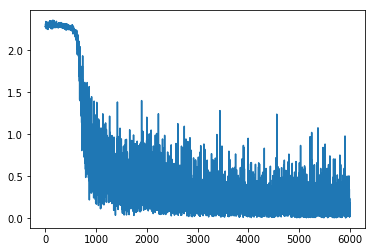

In [38]:
print("SGD")
plt.plot(losses3)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: